# Introduction

Date : 2023-07-02

Author : Mélody Merle

This notebook explains how stacks of gastruloid stained by immunofluorescence are analyzed. In my own codes, this is automatized for batch of gastruloids using Pandas DataFrames. This would be uploaded later.
The example is applied to a raw ".czi" file. To use the data available at https://zenodo.org/record/8108188 that are the max projection of gastruloids, the first step is irrelevant. You can start at 2-Morphological analysis of the gastruloid after loading the libraries.

# Load libraries

In [1]:
import os
import sys 

sys.path.append(os.path.join('../'))
print(sys.path)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


import src.image.imUtils as imu
import src.image.imUtilsJ as imuj
import src.analysis.medialaxis as ma
import src.analysis.pipelines as pip

import bioformats
import javabridge
import tifffile


# 1 - Process the stack image 
A ".czi" file. 
Gastruloids are imaged by confocal microscopy using a LSM980, with an objective 10x using the AiryScan mode. 
The analyzed filed is the processed file using the Zen software.

## Calculate the max projection of the file 
The stack obtained by confocal imaging is first max projected into a single image. 

In [3]:
file = "../data/gastruloid_test_IF.czi"

# each channel is max projected independently
metadata = imu.get_metadata(file)

Ns = metadata['Nseries']
Nx = metadata['Nx']
Ny = metadata['Ny']
Nc = metadata['Nch']

print('%d stacks of %d x %d images of %d channels' %(Ns, Nx, Ny, Nc))

15 stacks of 1920 x 1924 images of 3 channels


In [4]:
# Max projecting the gastruloids of theS gastruloid
theS=1

img_tiff = np.zeros([Nc, Ny, Nx])
for ch in range(Nc):
    img_ch, _ = imu.maxprojection(file, theS, theC =ch)
    img_tiff[ch,:,:] = img_ch

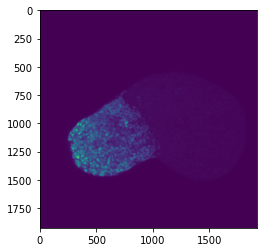

In [5]:
plt.figure()
plt.imshow(img_tiff[0,:,:])

In [6]:
# optional : save the projected image in a tif file
savefile = "../data/gastruloid_test_IF_S"+ str(theS) +".tif"
tifffile.imsave(savefile , img_tiff)

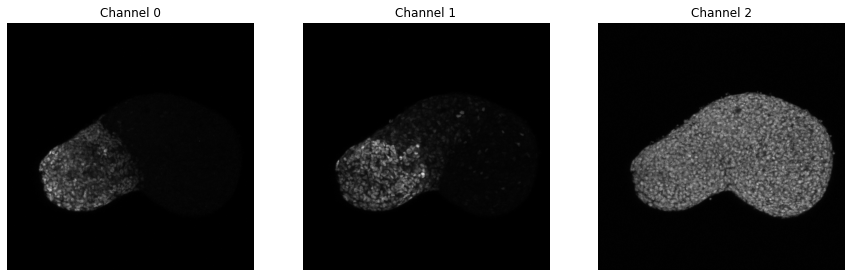

In [7]:
# show the image
fig, axs = plt.subplots(1,Nc,figsize=(15,5))
for ch in range(Nc):
    axs[ch].imshow( np.squeeze(img_tiff[ch,:,:]), cmap='gray')
    axs[ch].set_title('Channel ' + str(ch))
    axs[ch].axis('off')


In [8]:
dict_channel = {'Cdx2':0 , 'Sox2':1, 'DAPI':2}

## Extract useful metadata

In [9]:
um_per_pixel = metadata['dx']
print(um_per_pixel)

0.21959886128364403


# 2 - Morphological analysis of the gastruloid
Proceed to the morphogological analysis of the gastruloid. This is very similar to the morphological pipeline analysis for BF images, except that the binarization step is done a bit differently (see functions in imu for more details)
The morphological analysis is done using only the max projection of the DAPI channel.

In [10]:
# # If you want to directly use a tiff image that is a max projection: 
# savefile = "../data/gastruloid_test_IF_S1.tif"
# um_per_pixel = 0.22
# dict_channel = {'Cdx2':0 , 'Sox2':1, 'DAPI':2}

# img_tiff = tifffile.imread(savefile)

image_dapi = img_tiff[ dict_channel['DAPI'],:,:]


## Resize the image 
This is done to fasten the duration of the pipeline analysis, which is appreciated when you have multiple images to analyse. 
Need the um_per_pixel parameter, found in the metadata of the original files, see above. 
Another parameter is um_per_pixel_new, i.e. the final um_per_pixel you want to achieve; here 0.5µm/pixel.

In [11]:
um_per_pixel_new=0.5
coef = um_per_pixel_new/um_per_pixel
dim = tuple( [np.int(np.round(x/coef)) for x in image_dapi.shape])
image_resized = cv2.resize(image_dapi, dim, interpolation=cv2.INTER_AREA)
image=image_resized


## Get the contour 
1. Binarize
2. Smooth the contour
The active_contour is used to smooth the contour. Different parameters can be ajusted (see the skimage documentation for more details).

In [12]:
lbl = imu.binarize(image)
mask = imu.clean_binarized(lbl)
mask_arg = np.argwhere(mask).T
mask_cnt = imuj.bw_to_snake(mask)

# From this we can also get a bounding box BBOX
BBOX = [np.min(mask_arg[0]) - 100, np.max(mask_arg[0]) + 100, np.min(mask_arg[1]) - 100,
        np.max(mask_arg[1]) + 100]

cnt = imu.get_contour(mask, image, alpha=0.05, beta=0.5, w_line=0, w_edge=0)
cnt = np.asarray(cnt[0])


../src/image/imUtils.py:204: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  snake = active_contour(image,snake_init, alpha=alpha, beta=beta, w_line=w_line, w_edge=w_edge )


active contour done


(-0.5, 844.5, 842.5, -0.5)

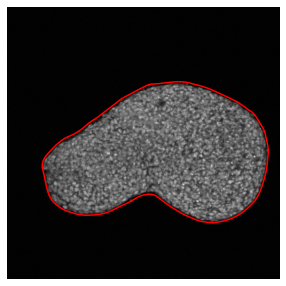

In [13]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow( image, cmap='gray')
xC,yC = cnt.T
axs.plot(yC, xC, c='r')
axs.axis('off')


## Calculate the midline
It consists in 
1. Calculating the medial axis
2. Extend it to find the two tips
From this, we directly get the length of the midline (in pixels).
See the function ma.get_axis_and_length for more details

In [14]:
MedialAxis, length = ma.get_axis_and_length( cnt, image)

print("Length = ", str(length*um_per_pixel), 'µm' )

Length =  167.86289703482814 µm


(-0.5, 844.5, 842.5, -0.5)

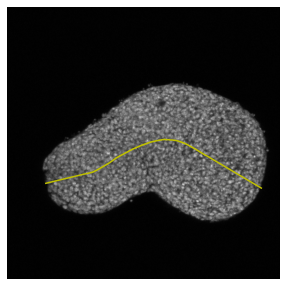

In [15]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow( image, cmap='gray')
xM,yM = MedialAxis.T
axs.plot(yM, xM, c='y')
axs.axis('off')


## Slice the gastruloid

In [16]:
nbin=50
volume, segments_bound, volumes, lengths, thicknesses = ma.bin_volume(MedialAxis, cnt, image, ndiv=nbin)

print("Volume = ", str(length*um_per_pixel**3), 'µm^3' )

removing each  1  first segments at each tip
Volume =  8.0949632525877 µm^3


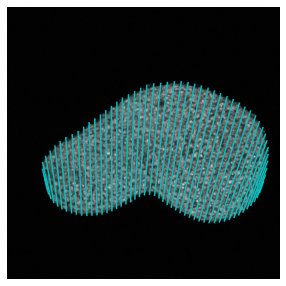

In [17]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow( image, cmap='gray')
axs.axis('off')

S = np.array(segments_bound).squeeze()
for seg in range(np.shape(S)[0]):
    if seg%1==0:
        axs.plot([S[seg, 0, 1], S[seg, 1, 1]], [S[seg, 0, 0], S[seg, 1, 0]], c='c')




## Resize everything to the real size !

In [18]:
mask_cnt = mask_cnt*coef
cnt = cnt*coef
BBOX= [x*coef for x in BBOX]
MedialAxis = coef*MedialAxis
length = length*coef
segments_bound= [np.array(segments_bound)*coef]
volume= volume*coef**3
volumes= [v *coef**3 for v in volumes]
lengths= [l*coef for l in lengths]


# 3 - Extract the profiles of expression 

## Prepare the data 
The profile analysis function is written on a Serie (format from the pandas library)


In [20]:
import pandas as pd 

serie_IF = pd.Series(
    {'absPath' : savefile, "channels": dict_channel, 
    "Lengths": lengths, "Segments": segments_bound, "Contour": cnt})

serie_IF['Areas'] = None

serie_IF['DAPI'] = None
serie_IF['Sox2'] = None
serie_IF['Cdx2'] = None
# serie_IF['Bra'] = None
# serie_IF['Foxc1'] = None

#TODO : maybe it would me worth now to write this function as an independant function
# that get the ID of each pixel of the image from the segment ! 
# and that could be independently used to calculate the profile or the volumes 
# I did not do that before because it means stocking an extraimage
# thus more memory needed : but could only used uint8 (or smaller)

In [21]:
results = pip.profiles_analysis(serie_IF)

tif!
shape (3, 1924, 1920)
ndiv 50
len segments 51


## Draw the profiles 

In [22]:
# Normalisation by the area first

sox = np.divide(results["Sox2"], results["Areas"])
cdx = np.divide(results["Cdx2"], results["Areas"])
dapi = np.divide(results["DAPI"], results["Areas"])


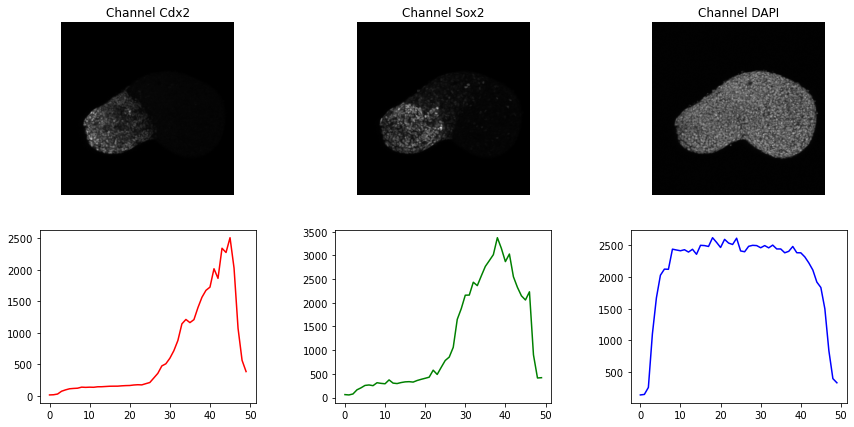

In [23]:
# Plot the profile next to the images 

fig, axs = plt.subplots(2,3,figsize=(15,7))
for(k,v) in dict_channel.items():
    axs[0][v].imshow(img_tiff[v,:,:], cmap='gray')
    axs[0][v].axis('off')
    axs[0][v].set_title('Channel ' + k)
    axs[0][v].set_box_aspect(1)
    
    axs[1][v].set_box_aspect(0.8)
    axs[1][v].set_box_aspect(0.8)
    
axs[1][dict_channel['Sox2']].plot(sox, c='g')
axs[1][dict_channel['Cdx2']].plot(cdx, c='r')
axs[1][dict_channel['DAPI']].plot(dapi, c='b')
